# (s, a, R, s, a, R, ...)という系列に対するゆらぎ解析

In [1]:
import gym
import d4rl # Import required to register environments
import numpy as np
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

No module named 'flow'
No module named 'carla'
pybullet build time: Mar  7 2022 18:18:14


In [114]:
def plot_fluctuation_scatter(
    data_name="halfcheetah-expert-v2",
    total_trajectory_len=1000,
    sub_trajectory_len=100,
    kmeans_pca='k-means',
    round_idx=2,
    n_clusters=10
    ):
    # load data
    env = gym.make(data_name)
    dataset = env.get_dataset()
    actions = dataset['actions'][:total_trajectory_len]
    observations = dataset['observations'][:total_trajectory_len]
    rewards = dataset['rewards'][:total_trajectory_len]
    return_to_go = [sum(rewards) if step == 0 else sum(rewards[:-step]) for step in range(total_trajectory_len)]
    return_to_go = np.array(return_to_go)[:, np.newaxis]

    if kmeans_pca == 'pca':
        action_feature = np.round(PCA(n_components=1).fit(actions).transform(actions), round_idx)
        state_feature = np.round(PCA(n_components=1).fit(observations).transform(observations), round_idx)
        return_feature = np.round(PCA(n_components=1).fit(return_to_go).transform(return_to_go), round_idx)
       
    elif kmeans_pca == 'k-means':
        action_feature = KMeans(n_clusters=n_clusters).fit(actions).fit_predict(actions)
        state_feature = KMeans(n_clusters=n_clusters).fit(observations).fit_predict(observations) + n_clusters  # action, returnとidx混同しないため
        return_feature = KMeans(n_clusters=n_clusters).fit(return_to_go).fit_predict(return_to_go) + int(2 * n_clusters)  # action, stateとidx混同しないため
    
    trajectory = []
    for step in range(total_trajectory_len):
        trajectory.append(action_feature[step])
        trajectory.append(state_feature[step])
        trajectory.append(return_feature[step])
 
    # count actions per sub-trajectories
    num_sub_trajectory = total_trajectory_len // sub_trajectory_len
    count_subsequences = np.zeros((num_sub_trajectory, len(np.unique(trajectory))))
    # TODO: 実際はaction, observation, return_to_go ごとにクラスを分けるべき
    for trajectory_id in tqdm(range(num_sub_trajectory)):
        feature_sub_seq = trajectory[trajectory_id * sub_trajectory_len * 3: (trajectory_id + 1) * sub_trajectory_len * 3]
        for feat in feature_sub_seq:
            for class_id, feature_class in enumerate(np.unique(trajectory)):
                if feat == feature_class:
                    count_subsequences[trajectory_id, class_id] += 1
    
    # calculate mean and standard deviation per sub-trajectory
    mean_list = np.array([count_subsequences[:, class_id].mean() for class_id in range(count_subsequences.shape[1])])
    std_list = np.array([count_subsequences[:, class_id].std() for class_id in range(count_subsequences.shape[1])]) + 1e-7
    
    # plot scatter
    plt.scatter(mean_list, std_list)
    plt.title(data_name)

    # linear fitting
    linear_model=np.polyfit(np.log(mean_list), np.log(std_list), 1)
    linear_model_fn=np.poly1d(linear_model)
    plt.plot(mean_list, np.exp(linear_model_fn(np.log(mean_list))), label=r'$\alpha$' + f': {linear_model[0]:.3f}', color='red')
    
    # plot
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.xlabel(r'Mean frequency of $a$, $s$, & $\hat{R}$ over sub-trajectories')
    plt.ylabel(r'Std of frequency of $a$, $s$, & $\hat{R}$ over sub-trajectories')
    plt.show()

In [109]:

# data_name="maze2d-large"
# total_trajectory_len=1000
# sub_trajectory_len=100
# kmeans_pca='k-means'
# round_idx=2
# n_clusters=10

# # load data
# env = gym.make(data_name)
# dataset = env.get_dataset()
# actions = dataset['actions'][:total_trajectory_len]
# observations = dataset['observations'][:total_trajectory_len]
# rewards = dataset['rewards'][:total_trajectory_len]
# return_to_go = [sum(rewards) if step == 0 else sum(rewards[:-step]) for step in range(total_trajectory_len)]
# return_to_go = np.array(return_to_go)[:, np.newaxis]

# if kmeans_pca == 'pca':
#     action_feature = np.round(PCA(n_components=1).fit(actions).transform(actions), round_idx)
#     state_feature = np.round(PCA(n_components=1).fit(observations).transform(observations), round_idx)
#     return_feature = np.round(PCA(n_components=1).fit(return_to_go).transform(return_to_go), round_idx)

# elif kmeans_pca == 'k-means':
#     action_feature = KMeans(n_clusters=n_clusters).fit(actions).fit_predict(actions)
#     state_feature = KMeans(n_clusters=n_clusters).fit(observations).fit_predict(observations) + n_clusters  # action, returnとidx混同しないため
#     return_feature = KMeans(n_clusters=n_clusters).fit(return_to_go).fit_predict(return_to_go) + int(2 * n_clusters)  # action, stateとidx混同しないため

# trajectory = []
# for step in range(total_trajectory_len):
#     trajectory.append(action_feature[step])
#     trajectory.append(state_feature[step])
#     trajectory.append(return_feature[step])

# # count actions per sub-trajectories
# num_sub_trajectory = total_trajectory_len // sub_trajectory_len
# count_subsequences = np.zeros((num_sub_trajectory, len(np.unique(trajectory))))
# # TODO: 実際はaction, observation, return_to_go ごとにクラスを分けるべき
# for trajectory_id in tqdm(range(num_sub_trajectory)):
#     feature_sub_seq = trajectory[trajectory_id * sub_trajectory_len * 3: (trajectory_id + 1) * sub_trajectory_len * 3]
#     for feat in feature_sub_seq:
#         for class_id, feature_class in enumerate(np.unique(trajectory)):
#             if feat == feature_class:
#                 count_subsequences[trajectory_id, class_id] += 1

# # calculate mean and standard deviation per sub-trajectory
# mean_list = np.array([count_subsequences[:, class_id].mean() for class_id in range(count_subsequences.shape[1])])
# std_list = np.array([count_subsequences[:, class_id].std() for class_id in range(count_subsequences.shape[1])]) + 1e-7

# # plot scatter
# plt.scatter(mean_list, std_list)
# plt.title(data_name)

# # linear fitting
# linear_model=np.polyfit(np.log(mean_list), np.log(std_list), 1)
# linear_model_fn=np.poly1d(linear_model)
# plt.plot(mean_list, np.exp(linear_model_fn(np.log(mean_list))), label=r'$\alpha$' + f': {linear_model[0]:.3f}', color='red')

# # plot
# plt.yscale('log')
# plt.xscale('log')
# plt.legend()
# plt.xlabel(r'Mean frequency of $a$, $s$, & $\hat{R}$ over sub-trajectories')
# plt.ylabel(r'Std of frequency of $a$, $s$, & $\hat{R}$ over sub-trajectories')
# plt.show()

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 14.07it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

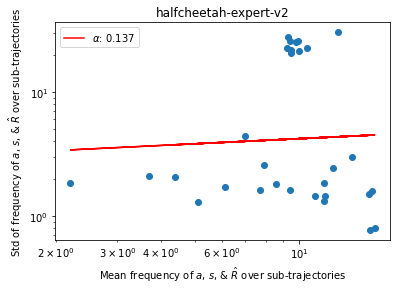

In [128]:
plot_fluctuation_scatter(
    data_name='halfcheetah-expert-v2',
    n_clusters=10,
    kmeans_pca='k-means',
    total_trajectory_len=1000,
    sub_trajectory_len=100)

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.11it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

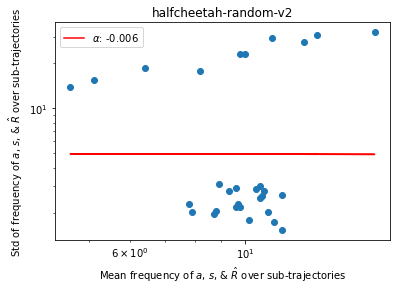

In [129]:
plot_fluctuation_scatter(
    data_name='halfcheetah-random-v2',
    kmeans_pca='k-means',
    n_clusters=10,
    total_trajectory_len=1000,
    sub_trajectory_len=100)

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 21.32it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

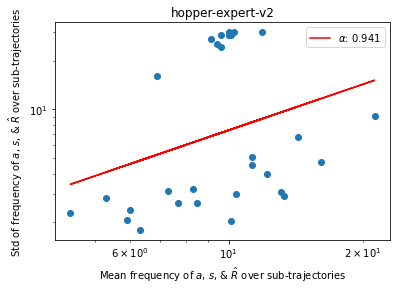

In [130]:
plot_fluctuation_scatter(
    data_name='hopper-expert-v2',
    kmeans_pca='k-means',
    n_clusters=10,
    total_trajectory_len=1000,
    sub_trajectory_len=100)

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 13.92it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

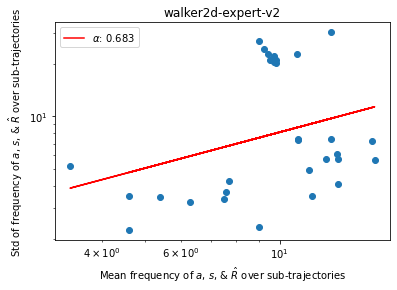

In [131]:
plot_fluctuation_scatter(
    data_name='walker2d-expert-v2',
    kmeans_pca='k-means',
    n_clusters=10,
    total_trajectory_len=1000,
    sub_trajectory_len=100)

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/envs/registration.py:511: UserWarning: WARN: Using the latest versioned environment `maze2d-large-v1` instead of the unversioned environment `maze2d-large`
  logger.warn(
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  7.89it/s]
/var/folders/vy/byytq3w13zx93_tkz5zl9qsr0000gn/T/ipykernel_6176/235035518.py:26: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_feature = KMeans(n_clusters=n_clusters).fit(return_to_go).fit_predict(return_to_go) + int(2 * n_clusters)  # action, stateとidx混同しないため
/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate poi

  0%|          | 0/10 [00:00<?, ?it/s]

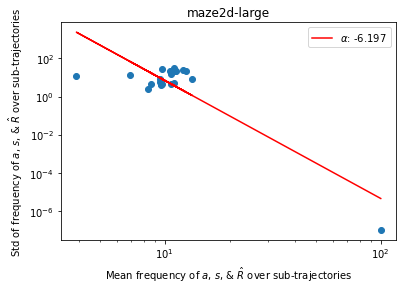

In [132]:
plot_fluctuation_scatter(
    data_name='maze2d-large',
    kmeans_pca='k-means',
    n_clusters=10,
    total_trajectory_len=1000,
    sub_trajectory_len=100)

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/envs/registration.py:511: UserWarning: WARN: Using the latest versioned environment `antmaze-large-play-v2` instead of the unversioned environment `antmaze-large-play`
  logger.warn(
/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Target Goal:  (32.61231965586054, 25.268749528998022)


load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.31it/s]
/var/folders/vy/byytq3w13zx93_tkz5zl9qsr0000gn/T/ipykernel_6176/235035518.py:26: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return_feature = KMeans(n_clusters=n_clusters).fit(return_to_go).fit_predict(return_to_go) + int(2 * n_clusters)  # action, stateとidx混同しないため
/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1255: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return self.fit(X, sample_weight=sample_weight).labels_


  0%|          | 0/10 [00:00<?, ?it/s]

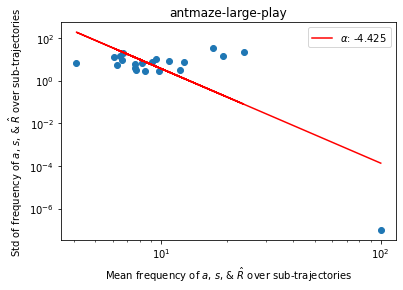

In [133]:
plot_fluctuation_scatter(
    data_name='antmaze-large-play',
    kmeans_pca='k-means',
    n_clusters=10,
    total_trajectory_len=1000,
    sub_trajectory_len=100)

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/envs/registration.py:511: UserWarning: WARN: Using the latest versioned environment `relocate-expert-v1` instead of the unversioned environment `relocate-expert`
  logger.warn(
/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:04<00:00,  4.87it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

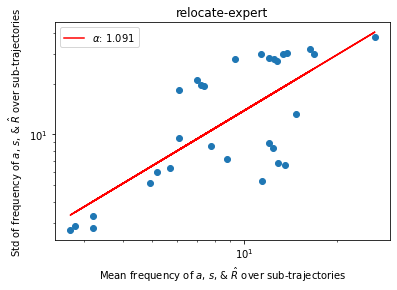

In [134]:
plot_fluctuation_scatter(
    data_name='relocate-expert',
    kmeans_pca='k-means',
    n_clusters=10,
    total_trajectory_len=1000,
    sub_trajectory_len=100)

Reading configurations for Franka
Initializing Franka sim


/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
load datafile: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 45.23it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

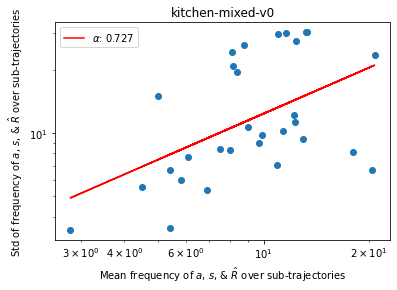

In [135]:
plot_fluctuation_scatter(
    data_name='kitchen-mixed-v0',
    kmeans_pca='k-means',
    n_clusters=10,
    total_trajectory_len=1000,
    sub_trajectory_len=100)